# Curve-fitting and parameter uncertainties
This notebook demonstrates fitting of a multi-parameter function to noisy data. In particular, it illustrates how to interpret the covariance matrix returned from ``scipy.optimize.curve_fit``, and how the apparent uncertainties on the solution are dependent on the exact choice of how the fitting function is expressed.

The problem scenario being modelled is peak-finding: fit a Gaussian function to data that is known to follow a Gaussian profile (with noise), in an attempt to estimate the coordinate of the centre of the distribution and assign an uncertainty to that value we have obtained.

*Written by Dr Jonathan Taylor, April 2020*

### Standard deviation from covariance matrix
The covariance matrix (returned from ``scipy.optimize.curve_fit`` as ``pcov``) represents the uncertainties in each unknown parameter that ``curve_fit`` is optimizing for [ * ]. If our unknown parameters are nice and independent of each other, the covariance matrix will be diagonal and all we need to do is to read off the diagonal elements of that matrix - these are the variances of each unknown parameter.

However, if there are inter-dependencies between the unknown parameters, i.e. changing the value of one parameter will cause the optimal value of other parameters to change, then it is rather more complicated to interpret the covariance matrix. This notebook explores this situation, and how to interpret the covariance matrix.


[ * ] Mathematically, it's rather neat how it is actually able to compute this, from looking at the Jacobian, i.e. the linear gradients of how the fit quality varies for *each individual* datapoint in ``ydata`` as a function of each unknown parameter

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [5]:
# Define various slightly different fitting functions that we will use in the code below
def GaussianUnnorm(x, A, x0, w):
    return float(A) * np.exp(-0.5*((x-x0)/float(w))**2)

def GaussianNorm(x, A, x0, w):
    return GaussianUnnorm(x, A, x0, w)/w/np.sqrt(2*np.pi)

def GaussianWithOffset(x, A, x0, w, B):
    return B + GaussianUnnorm(x, A, x0, w)

def GaussianWithOffset2(x, A, x0, w, B):
    return B + GaussianUnnorm(x, (A-B), x0, w)

def GaussianWithOffsetNorm(x, A, x0, w, B):
    return B + GaussianNorm(x, A, x0, w)

# Fitting a broad Gaussian, with and without noise
*Note: because of the random errors added to our datapoints, there can be variability from run to run - and sometimes the fit will fail entirely. To give an initial "sensible" illustration, I have hard-coded the random seed in the next cell. Feel free to disable that line to see how the behaviour varies from one run to the next.*

The following cell uses three different functions to fit to a dataset (consisting of a Gaussian, with noise added, sampled only in the region around the peak of the Gaussian). Note that all three functions describe a Gaussian (with a baseline offset). The only difference is in exactly how the parameters are used to make up the function - but any of the three functions can generate exactly the same plots, and so the "best" fit with each one should end up looking exactly the same. The only difference will be in the parameter values and the covariances.

### Fitting with function GaussianWithOffset
The uncertainty for x0 is low (there is a high confidence on where the centre of the Gaussian is located). The uncertainties for all three other parameters are high - curve_fit was not able to confidently determine their values. Why is that? Surely it's obvious what the amplitude is!?

The issue is that we have included an offset in our function. If we were to increase the offset but decrease the amplitude by the same amount then, *particularly for this example where we are only looking at the "top" of the Gaussian peak*, the fit would look very similar. Thus, curve_fit is struggling to determine what the "true" value of either the amplitude or the offset are. Note that this **has not affected** the accuracy with which it can determine the position of the centre. There is also a fairly high uncertainty on the width. That should not come as a surprise - when looking only at the top of the peak, it's hard to be sure what the width is.

Now examine the *covariances* (the off-diagonal elements). The covariance between the amplitude and the offset has a similar value to their individual uncertainties, but *negative*. This is telling us that the two parameters are coupled (they "co-vary" with one another), and that if one is increased then the other decreases by exactly the same amount - just as discussed in the previous paragraph.

Finally, let's actually think about the values returned from the fit. The overall fit looks plausible, but are the values returned actually consistent with the true values? We can compute sqrt(diag(cov)) to tell us the standard deviation for each parameter. Although the offset was not determined very accurately, all four returned values lie within one standard deviation of the true values.

### Fitting with function GaussianWithOffset2
We have carefully rewritten this function so that the A parameter determines the maximum value of the function and the B parameter the minimum, with the Gaussian spreading between those two limits. Thus, we have decoupled the two parameters - if we vary A then we wouldn't undo that change by varying B in the opposite direction. Now, the uncertainty on A is much smaller (A can be directly and unambiguously interpreted as the maximum of our new function GaussianWithOffset3). The uncertainties on the position and width have not changed. Interestingly, there is also a high negative covariance between the width and the offset - can you picture why that is?

*If* we cared about that high negative covariance between those two parameters, we could probably come up with an even better fitting function that would allow us to decouple them. Indeed, there should be a mathematically rigourous way of doing that by considering the eigenvectors of the covariance matrix...

### Fitting with function GaussianWithOffsetNorm
It might seem like the responsible thing to do, to fit with a "properly normalised" Gaussian (area under the curve equals 1, when parameter A is 1). The results with this get a bit complicated to interpret because the A parameter will come out rather larger now (thanks to the normalisation). However, notice that the covariance between w and A has gone up dramatically. This is of course because of the factor of w in the normalisation. If we change w, we have to also change A unless we want the height of the Gaussian function to change too.

## Varying the noise level
Edit the code in the next cell, to run for various different noise levels (run it just for GaussianWithOffset if you like, to reduce the amount of output generated). What do you see? The code prints out 'sigmas' - the number of standard deviations separating each parameter from its true value. You should see that, over a very wide range of noise levels, all the returned parameter values are statistically consistent with the parameter values we know were used to generate the data in the first place. This is reassuring! It suggests that we should be able to rely on the covariance matrix to give us a meaningful uncertainty on the values computed using our fitting.

## Data with no visible peak
Edit the code in the next cell to set the true width to 20. Over the x range considered, this is basically a flat function, and our data really does just look like noise. How does the fitting perform? Typically, the standard deviation reported on x0 is enormous (sometimes, even infinite). This is exactly what I hoped would happen! We shouldn't trust the result for x0 at all in that situation, and it is good to see that the covariance matrix is *telling us exactly that*.

===== Noise level 0.03 =====
Fitting with function GaussianWithOffset:


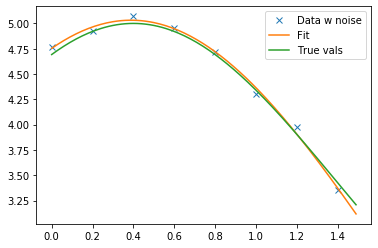

With noise 3.0e-02, fitted x0 is 0.3885 ± 0.0232. True x0 lies within 0.5 sigma
fit: [ 6.20610693  0.38854665  1.28264158 -1.17436698]
err: [4.81991404 0.02321628 0.58740539 4.84059603]
true: (4.0, 0.4, 1.0, 1)
sigmas: [0.4577067  0.49333269 0.48116954 0.44919406]
[[ 2.32315714e+01 -2.39749486e-02  2.82337616e+00 -2.33308526e+01]
 [-2.39749486e-02  5.38995842e-04 -3.69563099e-03  2.41682384e-02]
 [ 2.82337616e+00 -3.69563099e-03  3.45045090e-01 -2.83611577e+00]
 [-2.33308526e+01  2.41682384e-02 -2.83611577e+00  2.34313699e+01]]

Fitting with function GaussianWithOffset2:


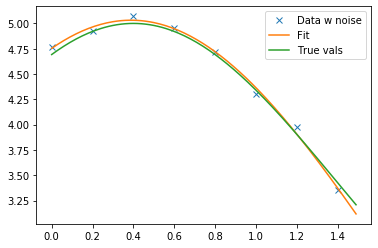

With noise 3.0e-02, fitted x0 is 0.3885 ± 0.0232. True x0 lies within 0.5 sigma
fit: [ 5.0317398   0.38854662  1.28264556 -1.17439982]
err: [0.03515934 0.02321667 0.58752774 4.84194748]
[[ 1.23617946e-03  1.93295045e-04 -1.27422924e-02  1.00546327e-01]
 [ 1.93295045e-04  5.39013573e-04 -3.69649836e-03  2.41765022e-02]
 [-1.27422924e-02 -3.69649836e-03  3.45188849e-01 -2.83750048e+00]
 [ 1.00546327e-01  2.41765022e-02 -2.83750048e+00  2.34444554e+01]]

Fitting with function GaussianWithOffsetNorm:


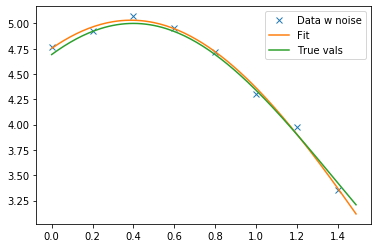

With noise 3.0e-02, fitted x0 is 0.3885 ± 0.0232. True x0 lies within 0.5 sigma
fit: [19.95357416  0.38854659  1.28264836 -1.17442296]
err: [2.46240512e+01 2.32165813e-02 5.87504729e-01 4.84169563e+00]
[[ 6.06343899e+02 -1.34606779e-01  1.44508348e+01 -1.19185004e+02]
 [-1.34606779e-01  5.39009647e-04 -3.69630408e-03  2.41747010e-02]
 [ 1.44508348e+01 -3.69630408e-03  3.45161806e-01 -2.83724138e+00]
 [-1.19185004e+02  2.41747010e-02 -2.83724138e+00  2.34420166e+01]]



In [7]:
# Generate and fit perfect Gaussian data (without any offset),
x = np.arange(0, 1.5, 0.2)
xx = np.arange(0, 1.5, 0.01)
trueVals = (4., 0.4, 1., 1)


# I have hard-coded the random seed to make the output reproducible.
# Disable this line to explore what happens with different instances of random noise.
np.random.seed(4)

# Fit a Gaussian in the presence of noise
for noiseLevel in [3e-2]:
# Or, try out a range of different noise levels by replacing the above line with the line below:
#for noiseLevel in [1e-4, 1e-3, 1e-2, 3e-2, 6e-2, 1e-1, 3e-1, 1]:
    print('===== Noise level {0} ====='.format(noiseLevel))
    # Generate the perfect dataset
    y = GaussianWithOffset(x, *trueVals)
    # Generate some noise. 
    noise = (np.random.random(y.shape)-0.5)*noiseLevel
    # Note that we treat noiseLevel as relative to the maximum value
    # in the y array. That helps keep things consistent if we use a function with different
    # normalisation (and hence different magnitudes of values)
    yn = y + noise*np.max(y)
    
    # My initial guesses are close to the true values.
    # I haven't played around much to see how 'wrong' the initial guesses can be.
    # There is some risk of getting stuck in a local minimum if the initially guesses aren't close-ish,
    # especially if we have almost as many free parameters as we do datapoints.
    for (func, initialGuess) in [(GaussianWithOffset, (5.,0.5,2., 0)),
                                 (GaussianWithOffset2, (5.,0.5,2., 2)),
                                 (GaussianWithOffsetNorm, (4.*5*np.sqrt(2*np.pi),0.5,2., 2))]:
        print('Fitting with function {0}:'.format(func.__name__))
        # Fit the ideal function to the noisy data
        params, covariance = optimize.curve_fit(func, x, yn, initialGuess, maxfev=100000)
        
        if True:
            # Plot the data and fits
            plt.plot(x, yn, 'x', label='Data w noise')
            plt.plot(xx, func(xx, *params), label='Fit')
            #plt.plot(xx, func(xx, *initialGuess), label='Initial guess')
            plt.plot(xx, GaussianWithOffset(xx, *trueVals), label='True vals')
            plt.legend()
            plt.show()

        # Report on the fit
        val = params[1]
        uncertainties = np.sqrt(np.diag(covariance))
        errs = params - trueVals
        print('With noise %.1e, fitted x0 is %.4f ± %.4f. True x0 lies within %.1f sigma' % (noiseLevel, val, uncertainties[1], np.abs(errs[1]/uncertainties[1])))
        print('fit:', params)
        print('err:', np.sqrt(np.diag(covariance)))
        if func is GaussianWithOffset:
            # I only print the true values if we are fitting with GaussianWithOffset.
            # That is because the true values will be different for each function
            # (since the parameters play slightly different roles in each function)
            # and so these values are not immediately available for other functions
            print('true:', trueVals)
            print('sigmas:', np.abs(errs/uncertainties))

        print(covariance)
        print('')